In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

Epoch 1/5
10/10 [==============================] - 0s 14ms/step - loss: 2.1568 - accuracy: 0.2940 - val_loss: 1.7982 - val_accuracy: 0.5340
Epoch 2/5
10/10 [==============================] - 0s 3ms/step - loss: 1.4155 - accuracy: 0.6480 - val_loss: 1.1691 - val_accuracy: 0.6720
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 0.8097 - accuracy: 0.7850 - val_loss: 0.7404 - val_accuracy: 0.7840
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 0.4288 - accuracy: 0.8910 - val_loss: 0.5924 - val_accuracy: 0.8240
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9490 - val_loss: 0.4954 - val_accuracy: 0.8440
Overall calculation took 0.5982100963592529 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________

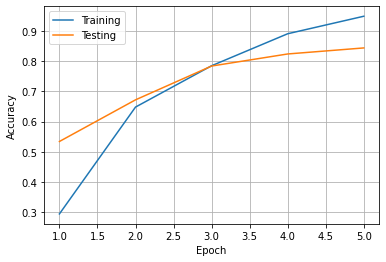

In [7]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model)
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
nn_save(model, "../models/model_test_small.h5")

In [8]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
 array([[ 0.01743369, -0.0448595 ,  0.01700593, ..., -0.08100501,
         -0.039437  , -0.01738876],
        [-0.05974199, -0.0050594 ,  0.01806217, ..., -0.04069512,
          0.04969868,  0.03359859],
        [-0.04995032,  0.06309575, -0.00772937, ..., -0.05693629,
          0.03480571, -0.04803716],
        ...,
        [ 0.06142421, -0.00991699,  0.04870585, ..., -0.05468635,
          0.06899758,  0.00282843],
        [-0.04510133,  0.04147224, -0.05598278, ...,  0.01716213,
         -0.0297642 ,  0.09859083],
        [-0.09908427,  0.00187593,  0.08837842, ...,  0.04840584,
          0.01531912,  0.0097312 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 0.04327018, -0.07381418,  0.03087016,  0.02236053,  0.05741595,
         0.03686375, -0.05570046, -0.0665051 , -0.09683847,  0.03811099,
         0.07938883,  0.0839301 ,  0.02294065,  0.13181856,  0.05242262,
    

In [9]:
model.history.history

{'loss': [2.1567821502685547,
  1.415523886680603,
  0.8096575140953064,
  0.4288073778152466,
  0.22122029960155487],
 'accuracy': [0.2939999997615814,
  0.6480000019073486,
  0.7850000262260437,
  0.890999972820282,
  0.9490000009536743],
 'val_loss': [1.7981798648834229,
  1.1691062450408936,
  0.7404221296310425,
  0.5924199819564819,
  0.49540990591049194],
 'val_accuracy': [0.5339999794960022,
  0.671999990940094,
  0.7839999794960022,
  0.8240000009536743,
  0.843999981880188]}

In [10]:
model.evaluate(X_val_small, y_val_small)

16/16 [==============================] - 0s 688us/step - loss: 0.4954 - accuracy: 0.8440


[0.49540990591049194, 0.843999981880188]

In [42]:
predictions = [np.argmax(i) for i in model.predict(X_val_small)]
actual = list(y_val_small.reset_index(drop = True).apply(lambda x: np.argmax(x), axis = 1))

for i in range(len(predictions)):
    print("Prediction: {}, Actual: {}, {}".format(predictions[i], actual[i], predictions[i] == actual[i]))

Prediction: 6, Actual: 6, True
Prediction: 4, Actual: 9, False
Prediction: 8, Actual: 8, True
Prediction: 5, Actual: 5, True
Prediction: 9, Actual: 9, True
Prediction: 9, Actual: 9, True
Prediction: 7, Actual: 7, True
Prediction: 9, Actual: 9, True
Prediction: 3, Actual: 3, True
Prediction: 2, Actual: 2, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 0, Actual: 6, False
Prediction: 9, Actual: 9, True
Prediction: 8, Actual: 8, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 4, Actual: 4, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 7, Actual: 9, False
Prediction: 9, Actual: 9, True
Prediction: 9, Actual: 5, False
Prediction: 4, Actual: 4, True
Prediction: 7, Actual: 7, True
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 5, Actual: 5, True
Prediction: 8, Actual: 8, True
Prediction: 9, Actual: 9, True
Pred